In [1]:
import numpy as np
import pandas as pd
import os.path
from datetime import datetime, timedelta
from scipy import stats

In [2]:
root_path = os.path.dirname(os.getcwd())

# Load inspections
inspections = pd.read_csv(os.path.join(root_path, "DATA/food_inspections.csv"))

# Load observation datasets
burglaries = pd.read_csv(os.path.join(root_path, "DATA/burglaries.csv"))
carts = pd.read_csv(os.path.join(root_path, "DATA/garbage_carts.csv"))
complaints = pd.read_csv(os.path.join(root_path, "DATA/sanitation_complaints.csv"))

In [3]:
# Create datetime columns
inspections["datetime"] = pd.to_datetime(inspections.inspection_date)
burglaries["datetime"] = pd.to_datetime(burglaries.date)
carts["datetime"] = pd.to_datetime(carts.creation_date)
complaints["datetime"] = pd.to_datetime(complaints.creation_date)

In [4]:
# FILTER: consider only inspections since 2012
# Otherwise early inspections have few/no observations within window
inspections = inspections.loc[inspections.inspection_date >= "2012"]

In [7]:
def get_kde(observations, column_name, window, bandwidth):

    # Sort chronologically and index by datetime
    observations.sort_values("datetime", inplace=True)
    observations.index = observations.datetime.values
    
    # Generate kernel from 90 days of observations
    def get_kde_given_date(group):
        stop = group.datetime.iloc[0]
        start = stop - timedelta(days=window)
        recent = observations.loc[start:stop]
        
        x1 = recent.longitude
        y1 = recent.latitude
        values = np.vstack([x1, y1])
        kernel = stats.gaussian_kde(values)

        x2 = group.longitude
        y2 = group.latitude
        samples = np.vstack([x2, y2])
        group[column_name] = kernel(samples)
        return group[["inspection_id", column_name]]

    # Group inspections by date, generate kernels, sample
    return inspections.groupby("inspection_date").apply(get_kde_given_date)

In [8]:
# Calculate kde given observation window, kernel bandwidth
burglary_kde = get_kde(burglaries, "burglary_kde", 90, 1)

In [9]:
# Calculate kde given observation window, kernel bandwidth
cart_kde = get_kde(carts, "cart_kde", 90, 1)

In [10]:
# Calculate kde given observation window, kernel bandwidth
complaint_kde = get_kde(complaints, "complaint_kde", 90, 1)

In [30]:
thing = pd.merge(inspections, cart_kde, on="inspection_id").sample(1000)

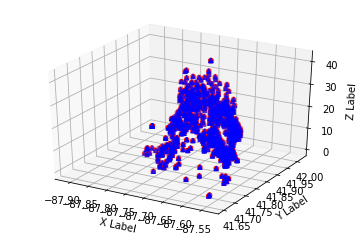

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = thing.longitude#randrange(n, 23, 32)
    ys = thing.latitude#randrange(n, 0, 100)
    zs = thing.cart_kde#randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [11]:
import os.path
root_path = os.path.dirname(os.getcwd())

In [12]:
# Save result
burglary_kde.to_csv(os.path.join(root_path, "DATA/burglary_kde.csv"), index=False)

In [13]:
# Save result
cart_kde.to_csv(os.path.join(root_path, "DATA/cart_kde.csv"), index=False)

In [14]:
# Save result
complaint_kde.to_csv(os.path.join(root_path, "DATA/complaint_kde.csv"), index=False)